In [1]:
# pip install -U "ray[default]"

In [2]:
# pip install secure-smtplib

In [3]:
# pip install ipython-autotime

This code is for 8 PAM, changing precoding and probabilistic shaping to obtain optimized secrecy capacity and BER from 10 to 40 dbm (with ber constrain) (RAY)


In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad as quad
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from numpy.lib.function_base import angle
from collections import defaultdict
import os
# from scipy (torch.__version__)
from scipy.misc import derivative as deri
%load_ext autotime
import ray
from IPython.display import display, HTML

2024-04-04 17:10:03,744	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


time: 313 ms (started: 2024-04-04 17:10:03 +07:00)


In [5]:
import numpy as np

class ParticleSwarmOptimization:
    def __init__(self, population_size, inertia_weight, cognitive_coefficient, social_coefficient, generations):
        self.population_size = population_size
        self.inertia_weight = inertia_weight
        self.cognitive_coefficient = cognitive_coefficient
        self.social_coefficient = social_coefficient
        self.generations = generations
    def add_ones(self, positions, x):
      ones_to_add = np.ones((positions.shape[0], x), dtype=int)
      return np.concatenate((positions, ones_to_add), axis=1)
    def initialize_particles(self, genes_length):
        # positions = np.random.rand(self.population_size-2, genes_length)
        
        positions = np.random.uniform(0.0000000001, 1, [self.population_size-6, int( genes_length+4)] )
        positions[:, :4] = np.random.uniform(-1, 1, [self.population_size-6, 4] )
        
#         new_positions = self.add_ones(new_positions, genes_length)
#         positions = np.append(positions,new_positions , axis=0)
        positions = np.append(positions, np.array([[ 1,1,-1,1,1.00000000e-12 ,1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12 ,1.00000000e-12, 1.00000000e-12, 1.00000000e+00,
 1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12]]), axis=0)
        positions = np.append(positions, np.array([[ 1,1,1,1,1.00000000e-12 ,1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12 ,1.00000000e-12, 1.00000000e-12, 1.00000000e+00,
 1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12]]), axis=0)
        positions = np.append(positions, np.array([[ 1,1,-1,1,1 ,1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12 ,1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
 1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1]]), axis=0)
        positions = np.append(positions, np.array([[ 1,1,1,1,1 ,1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12 ,1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
 1.00000000e-12, 1.00000000e-12, 1.00000000e-12, 1]]), axis=0)
        positions = np.append(positions, np.array([[ 1.00000000e+00, 1.00000000e-10, -1, 1.00000000e-10,
       1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]]), axis=0)
        positions = np.append(positions, np.array([[ 1.00000000e+00, 1.00000000e+00, -1, 1.00000000e+00,
       1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]]), axis=0)
#         positions = [[val + 0.0000000001 if val == 0 else val for val in array] for array in positions]
        velocities = np.zeros_like(positions)
        return positions, velocities


    def update_velocity(self, velocity, position, personal_best, global_best):
        inertia_term = self.inertia_weight * velocity
        cognitive_term = self.cognitive_coefficient * np.random.rand() * (personal_best - position)
        social_term = self.social_coefficient * np.random.rand() * (global_best - position)
        return inertia_term + cognitive_term + social_term

    def update_position(self, position, velocity):
        new_position = position + velocity

        new_position[:, :4] = np.clip(new_position[:, :4], -1,1)
        new_position[:, 4:] = np.clip(new_position[:, 4:], 0.00000000001,1)
#         positions = [[val + 0.000000001 if val == 0 else val for val in array] for array in positions]
   
#         new_position = (new_position, 0.00000000001,1)
        return new_position


    def calculate_fitness(self, positions, utility_function):
        return np.array([utility_function(position) for position in positions])

    def run_particle_swarm_optimization(self, para_genes_length, utility_function):
        genes_length = para_genes_length
        positions, velocities = self.initialize_particles(genes_length)

        personal_best_positions = positions.copy()
        personal_best_fitness = self.calculate_fitness(personal_best_positions, utility_function)

        global_best_index = np.argmax(personal_best_fitness)
        global_best_position = personal_best_positions[global_best_index]
        global_best_fitness = personal_best_fitness[global_best_index]
        stagnation_counter = 0
        max_stagnation = 49
        global_best_fitness_stag = 0

        for generation in range(self.generations):
            fitness = self.calculate_fitness(positions, utility_function)

            update_personal_best = fitness > personal_best_fitness
            personal_best_positions[update_personal_best] = positions[update_personal_best]
            personal_best_fitness[update_personal_best] = fitness[update_personal_best]

            # Update global best considering all particles
            if np.max(personal_best_fitness) > global_best_fitness:
                global_best_index = np.argmax(personal_best_fitness)
                global_best_position = personal_best_positions[global_best_index]
                global_best_fitness = personal_best_fitness[global_best_index]

            # Introduce elitism
            num_elite = int(self.population_size * 0.1)
            sorted_indices = np.argsort(fitness)
            elite_indices = sorted_indices[-num_elite:]
            elite_positions = positions[elite_indices]
            elite_fitness = fitness[elite_indices]

            # Update personal best for elite particles
            update_personal_best[elite_indices] = True
            personal_best_positions[elite_indices] = elite_positions
            personal_best_fitness[elite_indices] = elite_fitness

            # Ensure elite particles survive into the next generation
            positions[:num_elite] = elite_positions
            velocities[:num_elite] = velocities[elite_indices]

            # Update the remaining particles
            remaining_indices = sorted_indices[:-num_elite]
            velocities[remaining_indices] = self.update_velocity(velocities[remaining_indices], positions[remaining_indices], personal_best_positions[remaining_indices], global_best_position)
            positions[remaining_indices] = self.update_position(positions[remaining_indices], velocities[remaining_indices])

            # Update velocities and positions
            velocities = self.update_velocity(velocities, positions, personal_best_positions, global_best_position)
            positions = self.update_position(positions, velocities)

            # Check for stagnation
            if global_best_fitness_stag < global_best_fitness:
                global_best_fitness_stag = global_best_fitness
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            if stagnation_counter >= max_stagnation:
                print(f"\nStopping the algorithm in generation {generation} due to {max_stagnation} generations of no improvement {global_best_position}.")
                break

        # print(f"Compare:{bool(min(utility_function(np.array([1,1,0,1,1,1,1,1])) -global_best_fitness,0))}")
        # print(f"Compare:{bool(min(utility_function(np.array([5.65448355e-01, 1.00000000e+00, 1.00000000e-12, 1.00000000e-12, 9.83667516e-01, 1.00000000e-12, 1.00000000e-12 ,6.74240926e-03])) - global_best_fitness,0))}")
        print("\nOptimization Complete.")
        print("Best position:", global_best_position)
        print("Best Utility:", global_best_fitness)

        return global_best_position


time: 0 ns (started: 2024-04-04 17:10:03 +07:00)


In [6]:
#Heuristic search for adaptive precoder and shaping to optimize upper bound BER and precoding

%load_ext autotime
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
from scipy.stats import norm
import ray
# ray.init()

class adaptive_PAM_env_04:
    def __init__(self, optical_power, size):
        super(adaptive_PAM_env_04, self).__init__()
        self.M = size
        self.size = self.M                                                            # Desired PAM order <6
        self.ampnoise= 10**-7
        self.optical_power_W= 10**(optical_power/10 - 3)
        self.A_max= (self.optical_power_W / 0.44) *0.1 /self.ampnoise
        # print(self.A_max)
        self.x = (2*np.arange(1, self.M + 1)-self.M-1) * self.A_max / (self.M-1)
#         print(self.x)
        self.N_0 = 1                                                                              # Normalized Noise
        self.sigma = 1
        self.lamda = 0
        self.h_u = 0
        self.w = 0
        self.eta = 0.44
        # self.gamma = 1
        self.LEDnumber = 4
        self.X_amb = 10.93
        self.i_amb = 5*10**(-12)
        self.gamma = 0.73
        self.A_r = 1 *10 **(-4)
        self.Psi = 80*np.pi/180
        self.B_mod = 20 * 10**6  #MHZ
        # IDC = 0.1
        self.e= 1.602176634 * 10**(-19)
        self.power = 1                                                                                             # Power tính theo W
        self.noise_power= 10**(-12.882)                                                                              # giong bai cu, tính theo W, bai reinforcement learning cuar liang xiao
        self.LED_pos= np.matrix([[-np.sqrt(5), -np.sqrt(5), 3], [np.sqrt(5), -np.sqrt(5), 3],                        # vị trí mấy cái đèn
                                [np.sqrt(5), np.sqrt(5), 3], [-np.sqrt(5), np.sqrt(5), 3]])
        self.userstr =[0, 0, 0.5]                                                                                    # vị trí mấy cái ng dùng
        self.Evestr = [2.5, 2.5, 0.5]                                                                                      # vị trí mấy cái ng nghe lén
        self.User_pos = np.matrix(self.userstr)
        self.Eve_pos = np.matrix(self.Evestr)
        self.saveCap1=0
        self.goc=0
        self.goc_2=0
        self.SER_ub = 0
        self.secCap = 0
        self.utility = 0
    def Q_function(self, value):                                                                  # Homemade Q function
        return 0.5 - 0.5 * special.erf(value / np.sqrt(2))  # Q(f) = 0.5 - 0.5 erf(f/sqrt(2))
    def distance(self): #đã check, okeeee
      H1 = np.zeros((4,1));
      H2 = np.zeros((4,1));
      T = H1
      T_2 = H2
      Phita_2= H2
      Phita = H1
      for i in range(self.LEDnumber):
          for j in range(1): #sa
                #Vector between led and user position
              vector = self.LED_pos[i,:] - self.User_pos[0,:];
              #eve
              vector_2 = self.LED_pos[i,:] - self.Eve_pos[0,:];
              #Distance between led and user
              T[i,j] = np.linalg.norm(vector);
              #eve
              T_2[i,j] = np.linalg.norm(vector_2);

      self.khoangcach_u=T
      self.khoangcach_e=T_2
      # print(f"Phita {T, T_2}")
      return self.khoangcach_u, self.khoangcach_e
  #công thức tính góc theo code của anh sơn, khá là dễ hiểu công thức hình học cấp 3
    def angle(self): #okeee, vẫn đúng, anh sơn chơi độ, ở đây dùng radian
        H1 = np.zeros((4,1));
        H2 = np.zeros((4,1));
        T = H1;
        Phita = H1;
        T_2 = H2
        Phita_2= H2
        for i in range(self.LEDnumber):
            for j in range(1):
                vector = self.LED_pos[i,:] - self.User_pos[0,:];
                T[i,j] = np.linalg.norm(vector);

                vector_2 = self.LED_pos[i,:] - self.Eve_pos[0,:];
                T_2[i,j] = np.linalg.norm(vector_2);

                Phita[i,j] = np.arccos(2.5/T[i,j]);
                Phita_2[i,j] = np.arccos(2.5/T_2[i,j]);                           #chieu cao

        self.goc=Phita
        self.goc_2=Phita_2
        # print(f"Phita {Phita, Phita_2}")
        return self.goc, self.goc_2
    def calc_channelgain(self): # gain theo bài anh sơn
        self.SemiAngle       = 60 *np.pi/180
        self.lambertian_angle= 120*np.pi/180
        self.PD_FOV          = 60 *np.pi/180
        self.PD_RefracIndex  = 1.5                  # Reflective Index
        self.PD_OptFilGain   = 1                    # Optical Concentration Gain
        self.PD_Area         = 10**(-4)             # Square meter
        self.LEDConver       = 0.44                 # LED Conversion factor (W/A)
        self.PD_Responsivity  = 0.54                 # Responsivity of the PDs (A/W)

        l = -np.log(2)/np.log(np.cos(self.SemiAngle))
        L = (l + 1) * (np.cos(self.goc))**l / (2 * np.pi)

        G = self.PD_RefracIndex**2 / np.sin(self.PD_FOV)**2

        d = self.khoangcach_u

        # print(self.goc)
        gain_mostafa = self.PD_Area * (1/(d**2)) *  G  * np.cos(self.goc) *L
        # print(f"Gain{gain_mostafa}")
        self.chanGain_b = np.vstack(gain_mostafa)*self.LEDConver *self.PD_Responsivity

        l_2 = -np.log(2)/np.log(np.cos(self.SemiAngle))

        G_2 = self.PD_RefracIndex**2 / np.sin(self.PD_FOV)**2
        L_2 = (l_2 + 1) * (np.cos(self.goc_2))**l_2 / (2 * np.pi)
        d_2 = self.khoangcach_e
        gain_mostafa_2 = self.PD_Area *G_2  * (1/(d_2**2)) * np.cos(self.goc_2) *L_2
        # print(f"Gain{gain_mostafa_2}")
        self.chanGain_e = np.vstack(gain_mostafa_2)*self.LEDConver *self.PD_Responsivity
#         print(self.chanGain_e)
        return self.chanGain_b, self.chanGain_e

    def entropy_prob(self, y, w, prob, h ):#P_t_dBm ):

      p = 0
      Gaus1 = 1 / np.sqrt(2 * np.pi * self.sigma**2)
      noise = np.log2(2 * np.pi * np.e * self.sigma**2) / 2
      for i in range(self.M):
        t = np.sum(np.matmul(np.transpose(h),w )*self.x[i])

        p +=  prob[i] * Gaus1* np.exp(-(y - t)**2 / (2 * self.sigma**2))
      if p < 10**-300:
        p = 10**-300
      h_y= -p * np.log2(p)
      return h_y

    def gaussian11(self, y, W, prob, h):
      f = 0
      p = 0
      Gaus1 = 1 / np.sqrt(2 * np.pi * self.sigma**2)

      for i in range(self.M):
          t = np.sum(np.matmul(np.transpose(h),W )*self.x[i])
#           print(h.size)
          Gaus2 = np.exp(-(y - t)**2 / (2 * self.sigma**2))
          Gaus = Gaus1 * Gaus2
          f += prob[i] * Gaus
      # print(f)
      if f <= 0:
          f = 10**-300
      return f
    def entropy(self, y, W, prob, h):
                    f_y = -self.gaussian11(y, W, prob, h)*np.log2(self.gaussian11(y, W, prob, h))
                    return  f_y

    def loggau(self,y, W, prob, h):
      return np.log2(self.gaussian11(y, W, prob, h))


    def deri_order(self,mu, W, prob, h):#variable x, derivative at a, order k
        k_order = deri(self.loggau, x0 = mu, n=2, dx=1e-6, args=(W, prob, h), order = 11) / math.factorial(2)
        return k_order


    def zeroth_order_func3(self,W, prob, h):
      zeroth = 0
      for i in range(self.M ):
        t = np.sum(np.matmul(np.transpose(h),W )*self.x[i])
        zeroth = zeroth -self.loggau(t, W, prob, h)*prob[i]
      return zeroth


    def second_order_func_3(self,W, prob, h):
      F_func = 0
      sigma = 1
      for i in range(self.M):
        t = np.sum(np.matmul(np.transpose(h),W )*self.x[i])
        F_func = F_func + self.deri_order(t, W, prob, h)*prob[i]
      return F_func

    def aproximmate_entropy(self,W, prob, h):
      H = self.zeroth_order_func3(W, prob, h) - self.second_order_func_3(W, prob, h) *self.sigma**2
      return H
    def SER_ub1(self, W, prob, h):                 # find upper bound for error probability WCNC anh Thanh
      pmn = 0
#       print(prob)
#       d = 0
      sigma = 1
      prob = prob/np.sum(prob)
      W = W.astype(float)  # Convert to float
      W[W == 0] += 0.00000000001
      prob= prob.astype(float)  # Convert to float
      prob[prob == 0] += 0.00000000001
#       if self.M!= prob.size:
#         print("False")
#       else:
#         print(f"This is the size {self.M}, {prob.size}")
#       h = h *10**6
      SER_ub = 0
      for m in range(1, self.M + 1):
        for n in range(1, self.M + 1):
          if n != m:
            # This is the closed form equation (17)
            d = np.matmul(np.transpose(h),W ) * self.gamma * self.eta * (self.x[m-1] - self.x[n-1])
            pmn = (1/2) * math.erfc((2* (sigma**2) * np.log(prob[m-1]/prob[n-1]) + d**2)/(2 * np.sqrt(2) * sigma * abs(d)))
            SER_ub +=  prob[m - 1] * pmn

      SER_ub = SER_ub /math.log2(self.M)
#       if SER_ub < 1.998811994548001e-10:
#             print(W)

      return SER_ub
    def calculate_utility(self,w_p ):                                                             # Calculate 1/P_e for objective function
        utility = 0
        w_p = (np.array( w_p))
        W, prob = np.split(w_p, [4])
        W = W.astype(float)  # Convert to float
        W[W == 0] += 0.00000000001
        prob= prob.astype(float)  # Convert to float
        prob[prob == 0] += 0.00000000001
#       prob = (prob)
#         W = np.array([1,1,0,1])
#         prob = np.concatenate([prob, np.flip(prob)])
        prob = prob/np.sum(prob)
#         if self.M!= prob.size:
#             print("False")
#         else:
#             print(f"This is the size {self.M}, {prob.size}")
#         print(W, prob)
        #Aprox
        H2 = self.aproximmate_entropy(W, prob, self.chanGain_b) - self.aproximmate_entropy(W, prob, self.chanGain_e)
        # Real
#         H2 = quad(self.entropy, -math.inf, math.inf, args=(W,prob, self.chanGain_b,), limit = 5000)[0] - quad(self.entropy, -math.inf, math.inf, args=(W,prob, self.chanGain_e,), limit = 5000)[0]
        utility = H2
        BER = self.SER_ub1(W, prob, self.chanGain_b)
#         print(f"BER= {BER}")
#         print(f"result{w_p}")
#         print(f"aprrox{H}")
#         print(f"real{H}")
        if BER > 3.8* 1e-3:
            utility = H2- 1000000 * BER
#             self.A_max = np.array([0,0,0,0])
        else:
#             H = quad(self.entropy, -math.inf, math.inf, args=(W,prob, self.chanGain_b,), limit = 5000)[0] - quad(self.entropy, -math.inf, math.inf, args=(W,prob, self.chanGain_e,), limit = 5000)[0]
            utility = H2
#             print(f"BER= {BER}")
#             print(f"result{w_p}")
#             print(f"aprrox{H2}")

        return utility

    
cons_size = 16
Min_power = 36
Max_power = 46
Num_point = 1


pam_env = adaptive_PAM_env_04(Max_power,cons_size)
run_vari1 = np.linspace(Min_power,Num_point,Max_power)

plt.figure(figsize=(12,6))
output_ids_gen = []
output_ids_simu = []
output_ids_two = []
output_ids_upper = []
def run_pso_parallel(i,  size_p =cons_size, population_size= 3000 , inertia_weight=0.5,
                     cognitive_coefficient=2, social_coefficient=1.5, generations=150):
    pam_env = adaptive_PAM_env_04(i, size_p)
    pam_env.distance()
    pam_env.angle()
    pam_env.calc_channelgain()
    pso_algorithm = ParticleSwarmOptimization(population_size=population_size , inertia_weight=inertia_weight,
                                               cognitive_coefficient=cognitive_coefficient,
                                               social_coefficient=social_coefficient, generations=generations)
    # Run the PSO algorithm
    
    pos = pso_algorithm.run_particle_swarm_optimization(size_p, pam_env.calculate_utility)
    
#     w_p = (np.array( w_p))
    
    cap = pam_env.calculate_utility(pos)
    W, prob = np.split(pos, [4])
    prob = prob/sum(prob)
    ber = pam_env.SER_ub1(W, prob, pam_env.chanGain_b)
    
    return pos, cap, ber, i

# Parallelize the PSO algorithm using Ray
@ray.remote
def parallel_pso(i,  size_p ):
    return run_pso_parallel(i,  size_p)

# Set up Ray
# ray.init()

# Run PSO in parallel
pso_result = np.zeros(Max_power)
pso_position = np.zeros(1)
pso_pos = ray.get([parallel_pso.remote(i,  size_p=cons_size) for i in range(Min_power, Max_power, Num_point)])

print(pso_pos)



print("Optimization completed!")




The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


2024-04-04 17:10:06,656	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(parallel_pso pid=12620) C:\Users\DELL\AppData\Local\Temp\ipykernel_28248\3549257137.py:214: RuntimeWarning: divide by zero encountered in true_divide
(parallel_pso pid=12620) C:\Users\DELL\AppData\Local\Temp\ipykernel_28248\3549257137.py:214: RuntimeWarning: invalid value encountered in true_divide
(parallel_pso pid=20680) C:\Users\DELL\AppData\Local\Temp\ipykernel_28248\3549257137.py:214: RuntimeWarning: divide by zero encountered in true_divide [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(parallel_pso pid=20680) C:\Users\DELL\AppData\Local\Temp\ipykernel_28248\3549257137.py:214: RuntimeWarning: invalid value encountered in true_divide [repeated 2x across cluster]
(parallel_pso pid=11032) C:\Us

(parallel_pso pid=3796) 
(parallel_pso pid=3796) Stopping the algorithm in generation 98 due to 49 generations of no improvement [ 1.00000000e+00  1.00000000e+00 -1.07084381e-01  1.00000000e+00
(parallel_pso pid=3796)   1.00000000e-11  1.00000000e-11  1.00000000e-11  1.00000000e-11
(parallel_pso pid=3796)   3.63493726e-01  1.00000000e-11  1.00000000e-11  1.00000000e-11
(parallel_pso pid=3796)   1.00000000e-11  1.00000000e-11  1.00000000e-11  9.98294946e-01
(parallel_pso pid=3796)   1.00000000e-11  1.00000000e-11  1.00000000e-11  1.00000000e-11].
(parallel_pso pid=3796) 
(parallel_pso pid=3796) Optimization Complete.
(parallel_pso pid=3796) Best position: [ 1.00000000e+00  1.00000000e+00 -1.07084381e-01  1.00000000e+00
(parallel_pso pid=3796)   1.00000000e-11  1.00000000e-11  1.00000000e-11  1.00000000e-11
(parallel_pso pid=3796)   3.63493726e-01  1.00000000e-11  1.00000000e-11  1.00000000e-11
(parallel_pso pid=3796)   1.00000000e-11  1.00000000e-11  1.00000000e-11  9.98294946e-01
(para

<Figure size 1200x600 with 0 Axes>

time: 13h 5min 28s (started: 2024-04-04 17:10:03 +07:00)
(parallel_pso pid=11032) 
(parallel_pso pid=11032) Optimization Complete.
(parallel_pso pid=11032) Best position: [ 1.          1.         -0.11404371  1.          0.82395456  0.87935337
(parallel_pso pid=11032)   0.60813815  1.          0.84011263  0.70200052  0.91737483  1.
(parallel_pso pid=11032)   0.56461372  0.97611978  0.06677971  1.          1.          1.
(parallel_pso pid=11032)   0.94571811  0.34042883]
(parallel_pso pid=11032) Best Utility: 3.8894755106938246


[1.         1.         0.         1.         0.53387641 0.79094466
 0.37557326 0.18724745 0.18724745 0.37557326 0.79094466 0.53387641]
Result 0.00945282416495452


C:\Users\DELL\AppData\Local\Temp\ipykernel_28248\3945670072.py:38: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(name_str, a,'g*--')


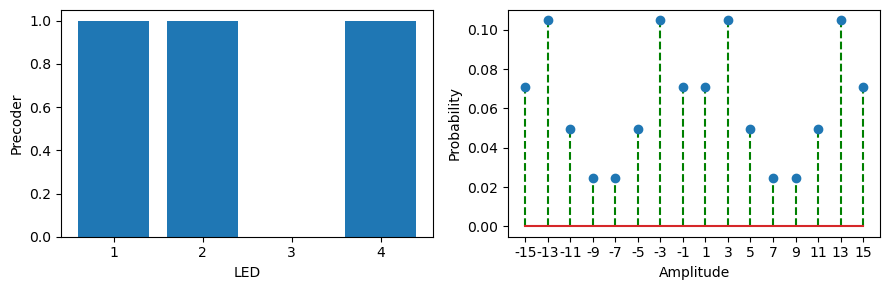

time: 312 ms (started: 2024-04-05 06:15:32 +07:00)


In [7]:
p = np.array([1,1,0,1, 0.53387641, 0.79094466, 0.37557326, 0.18724745, 0.18724745,
       0.37557326, 0.79094466, 0.53387641])
print(p)
p = np.concatenate([p, np.flip(p[4:])])
pam_env = adaptive_PAM_env_04(110, 16)
pam_env.distance()
pam_env.angle()
pam_env.calc_channelgain()
print(f"Result {pam_env.calculate_utility(p)}")
# p_test = np.array([9.62296811e-01, 1.00000000e+00 ,0, 1.00000000e+00,
#  1.00000000e+00, 1.00000000e-12, 1.00000000e+00, 1.00000000e-12,
#  8.36653050e-02, 1.00000000e+00, 1.00000000e-12, 1.00000000e-12])
# p_test = np.concatenate([p_test, np.flip(p_test[4:])])
# print(pam_env.calculate_utility(p))
# p = np.concatenate([p, np.flip(p[4:])])

for i in range(1):
    plt.figure(figsize=(9, 3))

    name = [-15,-13,-11,-9,-7,-5,-3, -1, 1, 3,5,7,9,11,13,15]
    name_str = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']
    LED = [1, 2, 3, 4]

    for j in range(len(name)):
        name_str[j] = str(name[j])
    plt.subplot(121)
    plt.bar(LED, p[:4])
    plt.xlabel('LED')
    plt.ylabel('Precoder')
    # plt.title('Subplot 1')

    a = p[4:]
    suma= sum(p[4:])
    for j in range(len(a)):
        a[j] = a[j] / suma

    plt.subplot(122)
    plt.stem(name_str, a,'g*--')
    plt.xlabel('Amplitude')
    plt.ylabel('Probability')
    # plt.title('Subplot 2')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


In [8]:
print(pso_results)

NameError: name 'pso_results' is not defined

time: 344 ms (started: 2024-04-05 06:15:32 +07:00)


In [ ]:
p = np.array([psotemp])
# p = np.array([9.84447764e-01, 9.84447764e-01, -1.14668294e-03, 9.82712270e-01,
#               3.89518506e-04, 1.00000000e+00, 8.55036822e-04, 4.66356042e-04,
#               3.98921473e-03, 9.92223882e-01, 5.95603846e-04, 1.17689200e-03,
#               1.00000000e-11, 9.92223882e-01, 7.77611822e-03, 1.57226146e-03,
#               2.02356585e-03, 9.92223882e-01, 4.54113397e-03, 3.28757838e-03])
print(p)
print(len(p))
for i in range(len(p)):
    plt.figure(figsize=(9, 3))

    name = [-7,-5,-3, -1, 1, 3,5,7]
    name_str = ['1','2','3','4','5','6','7','8']
    LED = [1, 2, 3, 4]

    for j in range(len(name)):
        name_str[j] = str(name[j])
    plt.subplot(121)
    plt.bar(LED, p[i][:4])
    plt.xlabel('LED')
    plt.ylabel('Precoder')
    # plt.title('Subplot 1')

    a = p[i][4:]
    for j in range(len(a)):
        a[j] = a[j] / sum(p[i][4:])

    plt.subplot(122)
    plt.stem(name_str, a,'g*--')
    plt.xlabel('Amplitude')
    plt.ylabel('Probability')
    # plt.title('Subplot 2')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


Sample Environment?

Test Cal_sigma WCNC

Test Cal A


Test cal_entropy